In [5]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Add pybounds to the path
sys.path.append(os.path.join(os.path.pardir, 'pybounds'))

# Import pybounds main classes
from simulator import Simulator
from observability import SlidingEmpiricalObservabilityMatrix, FisherObservability, ObservabilityMatrixImage, SlidingFisherObservability
from util import colorline

# Define system dynamics and measurements
This example uses a simple 2-state linear system with a single nonlinear measurement. The system corresponds to a single downward pointed camera moving in the horizontal direction. This is similar, but slightly different, from the example discussed in the following reference:

Floris van Breugel, Kristi Morgansen, and Michael H Dickinson
Monocular distance estimation from optic flow during active landing maneuvers.
Bioinspiration & Biomimetics, Volume 9, Number 2
DOI 10.1088/1748-3182/9/2/025002

The system dynamics are described by two states:
* ground speed $g$
* distance above the ground $d$

$$
\dot{\mathbf{x}} = \begin{bmatrix} \dot{g} \\ \dot{d} \end{bmatrix} = f(\mathbf{x}) = \begin{bmatrix} u \\ 0 \end{bmatrix}
$$

The system measurements are given by the ventral optic flow:
* $y = g/d$

$$
\mathbf{y} = h(\mathbf{x}) = \begin{bmatrix} g/d \end{bmatrix}
$$



## Define dynamics function

In [6]:
state_names = ['g', 'd']  # optional to specify state names
input_names = ['u'] # optional to specify input names
def f(X, U, t):
    # States
    g, d = X

    # Inputs
    u = U[0]

    # Dynamics
    g_dot = u
    d_dot = 0*u

    # Package and return xdot
    x_dot = [g_dot, d_dot]

    return x_dot

## Define measurement function 

In [7]:
measurement_names = ['y']  # optional to specify measurement names
def h(X, U, t):
    # States
    g, d = X

    # Inputs
    u = U

    # Measurements
    Y = [g/d]

    # Return measurement
    return Y


## Set time-step

In [8]:
dt = 0.01  # [s]

## Define initial state and controls
These can change later and is just to tell the simulator the size of the state & input vectors

In [9]:
X0 = [2, 3]  # [g, d]
U0 = [0]

# Create simulator object

In [10]:
simulator = Simulator(f, h, X0, U0, dt=dt,
                      state_names=state_names, measurement_names=measurement_names, input_names=input_names)

# Set the intital state

In [11]:
# Set the initial state
x0 = dict(g=2.0, d=3.0)

In [15]:
# Set the inputs
tsim1 = np.arange(0, 3, step=dt)
tsim2 = np.arange(3, 6, step=dt)
tsim3 = np.arange(6, 9, step=dt)
tsim = np.hstack((tsim1, tsim2, tsim3))

u1 = np.sin(3*tsim1)
u2 = 1e-5*np.sin(3*tsim2)
u3 = np.sin(3*tsim3)
u = np.hstack((u1, u2, u3))

(900,)

# Run simulator with set initial state & inputs

In [18]:
y = simulator.simulate(x0=x0, u=u)

In [20]:
# Store simulation data
t_sim, x_sim, u_sim, y_sim = simulator.get_time_states_input_measurements()

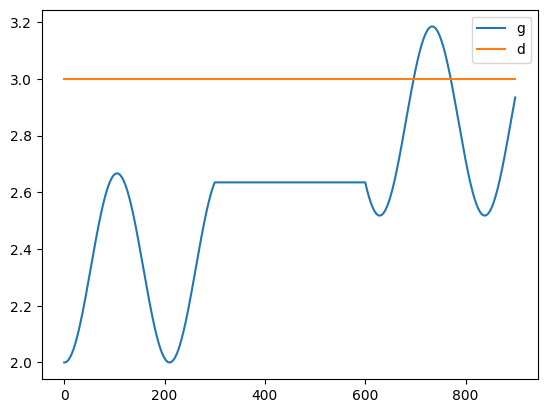

In [25]:
# Plot states
plt.plot(x_sim['g'], label='g')
plt.plot(x_sim['d'], label='d')
plt.legend()

# Observability

## Construct observability matrix in sliding windows

In [26]:
w = 6  # window size

In [27]:
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4, parallel=False)

In [28]:
n_window = len(SEOM.O_df_sliding)
print(n_window, 'windows')

895 windows


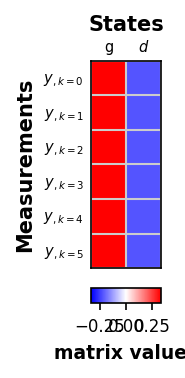

In [29]:
# Visualize observability matrix
OI = ObservabilityMatrixImage(SEOM.O_df_sliding[0], vmax_percentile=100, vmin_ratio=1.0, cmap='bwr')
OI.plot()

## Compute Fisher information matrix & inverse for each sliding window

In [34]:
# Choose sensors to use from O
o_sensors = ['y']

# Chose states to use from O
o_states = ['g', 'd']

# Choose time-steps to use from O
window_size = 6
o_time_steps = np.arange(0, window_size, step=1)

In [39]:
# Set each sensor noise levels
sensor_noise = {'y': 0.1}

In [40]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, sigma=1e-6, R=None, sensor_noise_dict=sensor_noise,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

In [43]:
EV_aligned = SFO.EV_aligned.copy()

In [153]:
EV_aligned

,time,time_initial,g,d
0,0.00,NaN,NaN,NaN
1,0.01,NaN,NaN,NaN
2,0.02,NaN,NaN,NaN
3,0.03,0.00,191444.779549,430320.587788
4,0.04,0.01,135294.535889,303881.279670
...,...,...,...,...
895,8.95,8.92,4321.249656,4656.471416
896,8.96,8.93,4385.102956,4693.069372
897,8.97,8.94,4457.770644,4738.574303
898,8.98,NaN,NaN,NaN


# Plot states & error variance

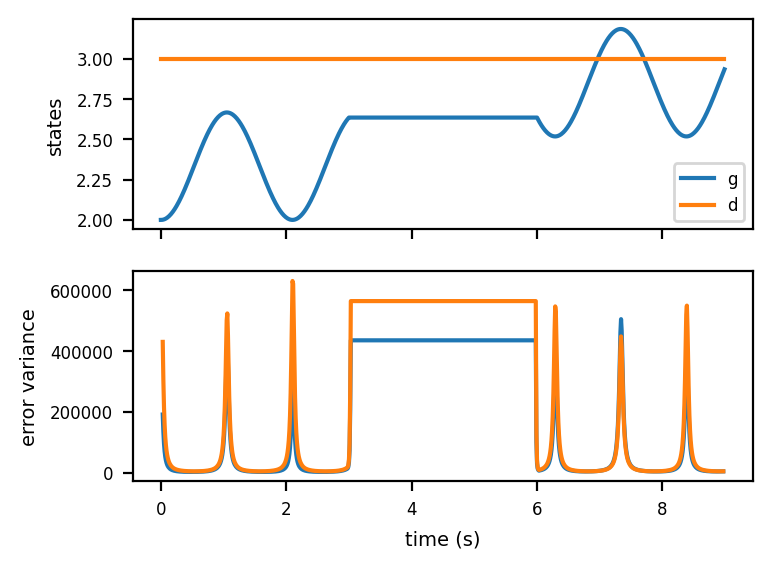

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3), dpi=200, sharex=True)

ax[0].plot(t_sim, x_sim['g'], label='g')
ax[0].plot(t_sim, x_sim['d'], label='d')
ax[0].set_ylabel('states', fontsize=7)
ax[0].legend(fontsize=6)

ax[1].plot(EV_aligned['time'], EV_aligned['g'])
ax[1].plot(EV_aligned['time'], EV_aligned['d'])
# ax[1].set_ylim(-1e5, 1e6)
ax[1].set_ylabel('error variance', fontsize=7)
ax[1].set_xlabel('time (s)', fontsize=7)
# ax[1].set_yscale('log')

for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)


# Plot error variance as color on state time-series

In [45]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

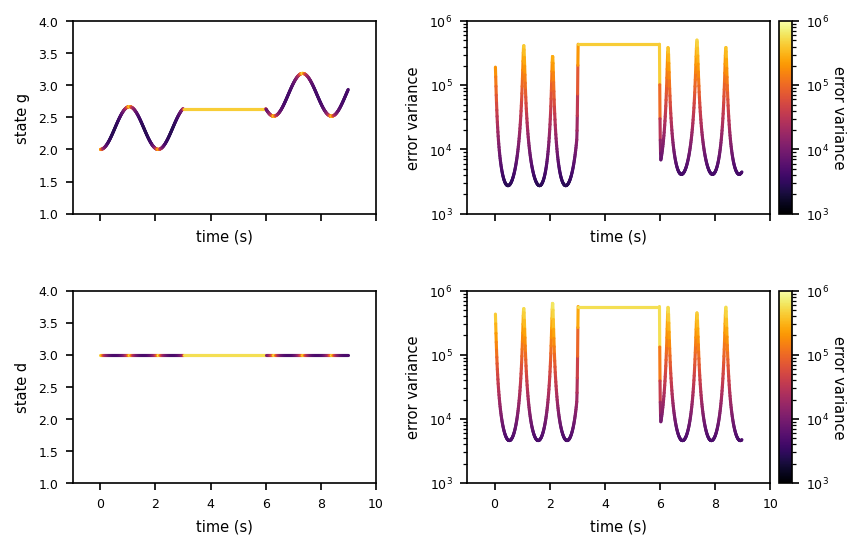

In [46]:
n_state = len(o_states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno'

log_tick_low = 3
log_tick_high = 6
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(o_states):
    colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('error variance', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(1, 4)
    ax[n, 0].set_ylabel('state ' + state_name, fontsize=7)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('error variance', fontsize=7)


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (s)', fontsize=7)
    a.set_xlim(-1, 10)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)